<a href="https://colab.research.google.com/github/gpmoran-16/BME3053C-Fall-2025/blob/main/interactive-exercises/Matrix_Transformations_10_20_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h2>Interactive Matrix Transformations</h2></center>

---

### Exercise Link: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/uf-bme/BME3053C-Fall-2025/blob/main/interactive-exercises/Matrix_Transformations.ipynb)

---

### Learning Objectives

By the end of this interactive exercise, you will be able to:

- **Understand transformation matrices**: Master translation, rotation, scaling, and shear transformations
- **Combine multiple transformations**: Learn how to chain transformations using matrix multiplication
- **Visualize transformation effects**: See real-time results of your transformation choices
- **Understand transformation order**: Discover why the order of transformations matters
- **Apply homogeneous coordinates**: Work with 3x3 matrices for 2D transformations

### Key Concepts

- **Translation**: Moving objects by adding to coordinates
- **Rotation**: Rotating objects around the origin
- **Scaling**: Changing the size of objects
- **Shear**: Skewing objects along an axis
- **Matrix multiplication order**: Understanding that T₁ × T₂ ≠ T₂ × T₁
- **Homogeneous coordinates**: Using [x, y, 1] representation for unified transformations

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
from matplotlib.patches import FancyArrowPatch

%matplotlib inline

In [2]:
# Helper functions for generating and plotting shapes

def generate_star(center=(0, 0), num_points=5, outer_radius=1, inner_radius=0.5):
    '''
    Generate the coordinates of a star shape in homogeneous coordinates.
    '''
    angles = np.linspace(np.pi/2, 5*np.pi/2, num_points*2, endpoint=False)
    radii = np.array([outer_radius, inner_radius] * num_points)
    x = radii * np.cos(angles) + center[0]
    y = radii * np.sin(angles) + center[1]
    # Return in homogeneous coordinates (x, y, 1)
    return np.column_stack((x, y, np.ones(num_points*2)))

def plot_shapes(original, transformed, transformations_applied):
    '''
    Plot original and transformed shapes side by side.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Calculate centers
    original_center = np.mean(original[:, :2], axis=0)
    transformed_center = np.mean(transformed[:, :2], axis=0)

    # Plot original
    ax1.plot(original[:, 0], original[:, 1], 'b-', linewidth=2, label='Original')
    ax1.plot([original[-1, 0], original[0, 0]], [original[-1, 1], original[0, 1]], 'b-', linewidth=2)
    ax1.scatter(original[0, 0], original[0, 1], c='red', s=100, zorder=5, label='First vertex')

    # Add arrow from center to first vertex (original)
    arrow1 = FancyArrowPatch(
        (original_center[0], original_center[1]),
        (original[0, 0], original[0, 1]),
        arrowstyle='->', mutation_scale=20, linewidth=2,
        color='purple', alpha=0.7, zorder=4
    )
    ax1.add_patch(arrow1)
    ax1.scatter(original_center[0], original_center[1], c='purple', s=50, marker='x', zorder=5, linewidths=2)

    ax1.set_title('Original Shape', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.axvline(0, color='black', linewidth=0.5)
    ax1.set_aspect('equal')
    ax1.legend()
    ax1.set_xlim(-6, 6)
    ax1.set_ylim(-6, 6)

    # Plot transformed
    ax2.plot(original[:, 0], original[:, 1], 'b--', linewidth=1, alpha=0.3, label='Original (reference)')
    ax2.plot([original[-1, 0], original[0, 0]], [original[-1, 1], original[0, 1]], 'b--', linewidth=1, alpha=0.3)
    ax2.plot(transformed[:, 0], transformed[:, 1], 'g-', linewidth=2, label='Transformed')
    ax2.plot([transformed[-1, 0], transformed[0, 0]], [transformed[-1, 1], transformed[0, 1]], 'g-', linewidth=2)
    ax2.scatter(transformed[0, 0], transformed[0, 1], c='red', s=100, zorder=5, label='First vertex')

    # Add arrow from center to first vertex (transformed)
    arrow2 = FancyArrowPatch(
        (transformed_center[0], transformed_center[1]),
        (transformed[0, 0], transformed[0, 1]),
        arrowstyle='->', mutation_scale=20, linewidth=2,
        color='purple', alpha=0.7, zorder=4
    )
    ax2.add_patch(arrow2)
    ax2.scatter(transformed_center[0], transformed_center[1], c='purple', s=50, marker='x', zorder=5, linewidths=2)

    ax2.set_title('Transformed Shape', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.5)
    ax2.axvline(0, color='black', linewidth=0.5)
    ax2.set_aspect('equal')
    ax2.legend()
    ax2.set_xlim(-6, 6)
    ax2.set_ylim(-6, 6)

    # Add transformation info
    if transformations_applied:
        info_text = "Transformations applied (in order):\n" + "\n".join(transformations_applied)
        plt.figtext(0.5, 0.02, info_text, ha='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0.1, 1, 1])
    plt.show()

In [3]:
# Transformation matrix functions

def translate(tx, ty):
    '''Translation matrix'''
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

def rotate(angle_degrees):
    '''Rotation matrix (counterclockwise)'''
    angle_radians = np.radians(angle_degrees)
    cos_theta = np.cos(angle_radians)
    sin_theta = np.sin(angle_radians)
    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])

def scale(sx, sy):
    '''Scaling matrix'''
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]
    ])

def shear(kx, ky):
    '''Shear matrix'''
    return np.array([
        [1, kx, 0],
        [ky, 1, 0],
        [0, 0, 1]
    ])

def identity():
    '''Identity matrix (no transformation)'''
    return np.eye(3)

In [4]:
# Interactive transformation widget

# Output widget for visualization
output = widgets.Output()

# Star position controls
star_center_x = widgets.FloatSlider(
    value=0, min=-5, max=5, step=0.5,
    description='Star Center X:',
    style={'description_width': '120px'}
)

star_center_y = widgets.FloatSlider(
    value=0, min=-5, max=5, step=0.5,
    description='Star Center Y:',
    style={'description_width': '120px'}
)

# Transformation type dropdowns
transform_options = ['None', 'Translate', 'Rotate', 'Scale', 'Shear']

transform1_type = widgets.Dropdown(
    options=transform_options,
    value='None',
    description='Transform 1:',
    style={'description_width': '100px'}
)

transform2_type = widgets.Dropdown(
    options=transform_options,
    value='None',
    description='Transform 2:',
    style={'description_width': '100px'}
)

transform3_type = widgets.Dropdown(
    options=transform_options,
    value='None',
    description='Transform 3:',
    style={'description_width': '100px'}
)

transform4_type = widgets.Dropdown(
    options=transform_options,
    value='None',
    description='Transform 4:',
    style={'description_width': '100px'}
)

# Parameter sliders for Transform 1
t1_tx = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TX:', style={'description_width': '40px'})
t1_ty = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TY:', style={'description_width': '40px'})
t1_angle = widgets.FloatSlider(value=0, min=-180, max=180, step=5, description='Angle:', style={'description_width': '40px'})
t1_sx = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SX:', style={'description_width': '40px'})
t1_sy = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SY:', style={'description_width': '40px'})
t1_kx = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KX:', style={'description_width': '40px'})
t1_ky = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KY:', style={'description_width': '40px'})

# Parameter sliders for Transform 2
t2_tx = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TX:', style={'description_width': '40px'})
t2_ty = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TY:', style={'description_width': '40px'})
t2_angle = widgets.FloatSlider(value=0, min=-180, max=180, step=5, description='Angle:', style={'description_width': '40px'})
t2_sx = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SX:', style={'description_width': '40px'})
t2_sy = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SY:', style={'description_width': '40px'})
t2_kx = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KX:', style={'description_width': '40px'})
t2_ky = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KY:', style={'description_width': '40px'})

# Parameter sliders for Transform 3
t3_tx = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TX:', style={'description_width': '40px'})
t3_ty = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TY:', style={'description_width': '40px'})
t3_angle = widgets.FloatSlider(value=0, min=-180, max=180, step=5, description='Angle:', style={'description_width': '40px'})
t3_sx = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SX:', style={'description_width': '40px'})
t3_sy = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SY:', style={'description_width': '40px'})
t3_kx = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KX:', style={'description_width': '40px'})
t3_ky = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KY:', style={'description_width': '40px'})

# Parameter sliders for Transform 4
t4_tx = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TX:', style={'description_width': '40px'})
t4_ty = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='TY:', style={'description_width': '40px'})
t4_angle = widgets.FloatSlider(value=0, min=-180, max=180, step=5, description='Angle:', style={'description_width': '40px'})
t4_sx = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SX:', style={'description_width': '40px'})
t4_sy = widgets.FloatSlider(value=1, min=0.1, max=3, step=0.1, description='SY:', style={'description_width': '40px'})
t4_kx = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KX:', style={'description_width': '40px'})
t4_ky = widgets.FloatSlider(value=0, min=-2, max=2, step=0.1, description='KY:', style={'description_width': '40px'})

# Create containers for each transform's parameters
t1_translate_params = widgets.VBox([t1_tx, t1_ty])
t1_rotate_params = widgets.VBox([t1_angle])
t1_scale_params = widgets.VBox([t1_sx, t1_sy])
t1_shear_params = widgets.VBox([t1_kx, t1_ky])
t1_params_container = widgets.VBox([])

t2_translate_params = widgets.VBox([t2_tx, t2_ty])
t2_rotate_params = widgets.VBox([t2_angle])
t2_scale_params = widgets.VBox([t2_sx, t2_sy])
t2_shear_params = widgets.VBox([t2_kx, t2_ky])
t2_params_container = widgets.VBox([])

t3_translate_params = widgets.VBox([t3_tx, t3_ty])
t3_rotate_params = widgets.VBox([t3_angle])
t3_scale_params = widgets.VBox([t3_sx, t3_sy])
t3_shear_params = widgets.VBox([t3_kx, t3_ky])
t3_params_container = widgets.VBox([])

t4_translate_params = widgets.VBox([t4_tx, t4_ty])
t4_rotate_params = widgets.VBox([t4_angle])
t4_scale_params = widgets.VBox([t4_sx, t4_sy])
t4_shear_params = widgets.VBox([t4_kx, t4_ky])
t4_params_container = widgets.VBox([])

def get_transform_matrix(transform_type, tx, ty, angle, sx, sy, kx, ky):
    '''Get the appropriate transformation matrix based on type and parameters'''
    if transform_type == 'Translate':
        return translate(tx, ty)
    elif transform_type == 'Rotate':
        return rotate(angle)
    elif transform_type == 'Scale':
        return scale(sx, sy)
    elif transform_type == 'Shear':
        return shear(kx, ky)
    else:  # 'None'
        return identity()

def update_params_visibility(change, params_container, translate_params, rotate_params, scale_params, shear_params):
    '''Update which parameter sliders are visible based on transformation type'''
    transform_type = change['new']
    if transform_type == 'Translate':
        params_container.children = [translate_params]
    elif transform_type == 'Rotate':
        params_container.children = [rotate_params]
    elif transform_type == 'Scale':
        params_container.children = [scale_params]
    elif transform_type == 'Shear':
        params_container.children = [shear_params]
    else:
        params_container.children = []
    update_visualization()

def update_visualization(*args):
    '''Update the visualization when any parameter changes'''
    with output:
        output.clear_output(wait=True)

        # Generate star with current center position
        original_shape = generate_star(center=(star_center_x.value, star_center_y.value),
                                       outer_radius=1.5, inner_radius=0.7)

        # Get all transformation matrices
        T1 = get_transform_matrix(transform1_type.value, t1_tx.value, t1_ty.value,
                                   t1_angle.value, t1_sx.value, t1_sy.value, t1_kx.value, t1_ky.value)
        T2 = get_transform_matrix(transform2_type.value, t2_tx.value, t2_ty.value,
                                   t2_angle.value, t2_sx.value, t2_sy.value, t2_kx.value, t2_ky.value)
        T3 = get_transform_matrix(transform3_type.value, t3_tx.value, t3_ty.value,
                                   t3_angle.value, t3_sx.value, t3_sy.value, t3_kx.value, t3_ky.value)
        T4 = get_transform_matrix(transform4_type.value, t4_tx.value, t4_ty.value,
                                   t4_angle.value, t4_sx.value, t4_sy.value, t4_kx.value, t4_ky.value)

        # Combine transformations (applied right to left: T4 * T3 * T2 * T1)
        combined_transform = T4 @ T3 @ T2 @ T1

        # Apply transformation
        transformed_shape = (combined_transform @ original_shape.T).T

        # Track which transformations were applied
        transformations_applied = []
        for i, (t_type, t_val) in enumerate([
            (transform1_type.value, [t1_tx.value, t1_ty.value, t1_angle.value, t1_sx.value, t1_sy.value, t1_kx.value, t1_ky.value]),
            (transform2_type.value, [t2_tx.value, t2_ty.value, t2_angle.value, t2_sx.value, t2_sy.value, t2_kx.value, t2_ky.value]),
            (transform3_type.value, [t3_tx.value, t3_ty.value, t3_angle.value, t3_sx.value, t3_sy.value, t3_kx.value, t3_ky.value]),
            (transform4_type.value, [t4_tx.value, t4_ty.value, t4_angle.value, t4_sx.value, t4_sy.value, t4_kx.value, t4_ky.value])
        ], 1):
            if t_type != 'None':
                if t_type == 'Translate':
                    transformations_applied.append(f"{i}. Translate: TX={t_val[0]:.1f}, TY={t_val[1]:.1f}")
                elif t_type == 'Rotate':
                    transformations_applied.append(f"{i}. Rotate: {t_val[2]:.0f}°")
                elif t_type == 'Scale':
                    transformations_applied.append(f"{i}. Scale: SX={t_val[3]:.1f}, SY={t_val[4]:.1f}")
                elif t_type == 'Shear':
                    transformations_applied.append(f"{i}. Shear: KX={t_val[5]:.1f}, KY={t_val[6]:.1f}")

        # Plot the shapes
        plot_shapes(original_shape, transformed_shape, transformations_applied)

def update_equation_display(*args):
    '''Update the transformation equation display'''
    # Build equation string
    transforms = [
        (transform1_type.value, '1', '#1976d2'),
        (transform2_type.value, '2', '#388e3c'),
        (transform3_type.value, '3', '#f57c00'),
        (transform4_type.value, '4', '#7b1fa2')
    ]

    # Filter out 'None' transformations
    active_transforms = [(t, n, c) for t, n, c in transforms if t != 'None']

    if not active_transforms:
        equation_html = """
        <div style='background-color: #fff9c4; padding: 15px; border-radius: 8px; margin: 10px 0; border: 2px solid #fbc02d;'>
            <h3 style='margin-top: 0; color: #f57f17;'>📐 Transformation Equation</h3>
            <p style='font-size: 20px; text-align: center; font-family: monospace; margin: 15px 0;'>
                <strong>Combined = I</strong>
            </p>
            <div style='margin-top: 10px; text-align: center;'>
                <span style='color: #666;'><strong>I</strong> = Identity Matrix (no transformation)</span>
            </div>
            <p style='margin-top: 15px; margin-bottom: 5px; font-size: 14px; color: #555;'>
                <em>Select transformation types above to build your transformation sequence.</em>
            </p>
        </div>
        """
    else:
        # Build the equation from right to left (reverse order for display)
        equation_parts = []
        for t_type, num, color in reversed(active_transforms):
            equation_parts.append(f"<span style='color: {color}; font-weight: bold;'>T<sub>{num}</sub></span>")

        equation = " × ".join(equation_parts)

        # Add explanation of each transform
        details_html = "<div style='margin-top: 10px;'>"
        for t_type, num, color in active_transforms:
            details_html += f"<span style='color: {color}; font-weight: bold;'>T<sub>{num}</sub></span> = {t_type} &nbsp;&nbsp;"
        details_html += "</div>"

        equation_html = f"""
        <div style='background-color: #fff9c4; padding: 15px; border-radius: 8px; margin: 10px 0; border: 2px solid #fbc02d;'>
            <h3 style='margin-top: 0; color: #f57f17;'>📐 Transformation Equation</h3>
            <p style='font-size: 20px; text-align: center; font-family: monospace; margin: 15px 0;'>
                <strong>Combined = {equation}</strong>
            </p>
            {details_html}
            <p style='margin-top: 15px; margin-bottom: 5px; font-size: 14px; color: #555;'>
                <strong>⚠️ Remember:</strong> Transformations are applied from <strong>right to left</strong> in the equation,<br/>
                but executed in order from Transform 1 → Transform 2 → Transform 3 → Transform 4.
            </p>
        </div>
        """

    equation_display.value = equation_html

# Create equation display widget
equation_display = widgets.HTML(value="")

# Link dropdown changes to parameter visibility updates
transform1_type.observe(lambda change: update_params_visibility(
    change, t1_params_container, t1_translate_params, t1_rotate_params, t1_scale_params, t1_shear_params), 'value')
transform2_type.observe(lambda change: update_params_visibility(
    change, t2_params_container, t2_translate_params, t2_rotate_params, t2_scale_params, t2_shear_params), 'value')
transform3_type.observe(lambda change: update_params_visibility(
    change, t3_params_container, t3_translate_params, t3_rotate_params, t3_scale_params, t3_shear_params), 'value')
transform4_type.observe(lambda change: update_params_visibility(
    change, t4_params_container, t4_translate_params, t4_rotate_params, t4_scale_params, t4_shear_params), 'value')

# Link all parameter changes to visualization update
for widget in [star_center_x, star_center_y,
               t1_tx, t1_ty, t1_angle, t1_sx, t1_sy, t1_kx, t1_ky,
               t2_tx, t2_ty, t2_angle, t2_sx, t2_sy, t2_kx, t2_ky,
               t3_tx, t3_ty, t3_angle, t3_sx, t3_sy, t3_kx, t3_ky,
               t4_tx, t4_ty, t4_angle, t4_sx, t4_sy, t4_kx, t4_ky]:
    widget.observe(update_visualization, 'value')

# Link transformation type changes to equation display update
for transform_type in [transform1_type, transform2_type, transform3_type, transform4_type]:
    transform_type.observe(update_equation_display, 'value')

# Create the UI layout
transform1_box = widgets.VBox([
    widgets.HTML("<h3 style='color: #1976d2;'>Transform 1 (Applied First)</h3>"),
    transform1_type,
    t1_params_container
], layout=widgets.Layout(border='2px solid #1976d2', padding='10px', margin='5px'))

transform2_box = widgets.VBox([
    widgets.HTML("<h3 style='color: #388e3c;'>Transform 2</h3>"),
    transform2_type,
    t2_params_container
], layout=widgets.Layout(border='2px solid #388e3c', padding='10px', margin='5px'))

transform3_box = widgets.VBox([
    widgets.HTML("<h3 style='color: #f57c00;'>Transform 3</h3>"),
    transform3_type,
    t3_params_container
], layout=widgets.Layout(border='2px solid #f57c00', padding='10px', margin='5px'))

transform4_box = widgets.VBox([
    widgets.HTML("<h3 style='color: #7b1fa2;'>Transform 4 (Applied Last)</h3>"),
    transform4_type,
    t4_params_container
], layout=widgets.Layout(border='2px solid #7b1fa2', padding='10px', margin='5px'))

# Display the interface
display(widgets.VBox([
    widgets.HTML("""
        <div style='background-color: #e3f2fd; padding: 15px; border-radius: 8px; margin-bottom: 15px;'>
            <h2 style='margin-top: 0; color: #1976d2;'>🔄 Interactive Matrix Transformation Builder</h2>
            <p style='margin-bottom: 0;'>
                <strong>Instructions:</strong> Select up to 4 transformations and adjust their parameters below.
                Transformations are applied in order from Transform 1 to Transform 4 (T4 × T3 × T2 × T1).
            </p>
            <p style='margin-bottom: 0; margin-top: 10px;'>
                <strong>Tip:</strong> Try different orders of the same transformations to see how order matters!
            </p>
        </div>
    """),
    widgets.HTML("<h3 style='color: #d32f2f; margin-top: 10px;'>⭐ Star Position</h3>"),
    widgets.HBox([star_center_x, star_center_y]),
    equation_display,
    widgets.HBox([transform1_box, transform2_box]),
    widgets.HBox([transform3_box, transform4_box]),
    output
]))

# Initial visualization and equation display
update_equation_display()
update_visualization()

## 🎯 Try These Challenges!

### Challenge 1: Order Matters
1. Set Transform 1 to **Rotate** by 90°
2. Set Transform 2 to **Translate** by TX=2, TY=0
3. Observe the result
4. Now swap them: Transform 1 = Translate (2,0), Transform 2 = Rotate 90°
5. **Question:** Why are the results different?

### Challenge 2: Create a Mirror Effect
1. Use **Scale** with SX=-1, SY=1 to reflect across the Y-axis
2. Add a **Translate** to move it to a new position
3. **Question:** What happens if you translate first, then reflect?

### Challenge 3: Complex Transformation
Try to recreate this transformation sequence:
1. Scale by 0.5 in both directions
2. Rotate by 45°
3. Shear with KX=0.5
4. Translate by (2, 2)

**Observe:** How does each transformation affect the previous result?

### Challenge 4: Return to Origin
1. Set Transform 1 to **Translate** by (3, 2)
2. Can you use Transform 2 to bring the star back to the origin?
3. **Hint:** What is the inverse of translation?

### Challenge 5: Create Your Own
Design a transformation sequence that:
- Uses all 4 transformation slots
- Creates an interesting final shape
- Then try to reverse it using another set of 4 transformations!

## 📊 Understanding the Combined Matrix

When you combine transformations, the final transformation matrix is:

$$\text{Combined} = T_4 \times T_3 \times T_2 \times T_1$$

This means:
- **Transform 1** is applied first to the original shape
- **Transform 2** is applied to the result of Transform 1
- **Transform 3** is applied to the result of Transform 2
- **Transform 4** is applied last

### Key Points:
1. **Matrix multiplication is not commutative**: $A \times B \neq B \times A$
2. **Transformations are applied right-to-left** in the matrix multiplication
3. **Each transformation uses the coordinate system of the previous result**
4. **Homogeneous coordinates** (the [x, y, 1] representation) allow us to represent all transformations as matrix multiplications

## 🧮 Exercise: Build Your Own Transformation

Use the code below to experiment with creating specific transformations programmatically:

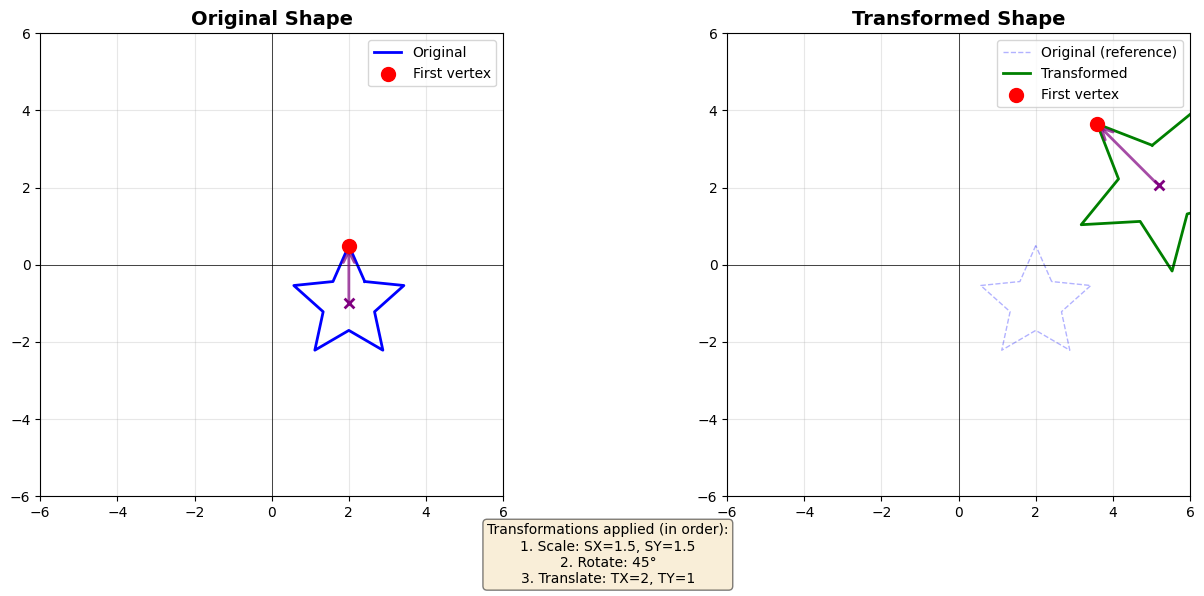


Combined Transformation Matrix:
[[ 1.06066017 -1.06066017  2.        ]
 [ 1.06066017  1.06066017  1.        ]
 [ 0.          0.          1.        ]]

Matrix shape: (3, 3)


In [ ]:
# Create your own transformation sequence here

# Get the current star position from the interactive widget
original_shape = generate_star(center=(star_center_x.value, star_center_y.value),
                               outer_radius=1.5, inner_radius=0.7)

# Example: Scale, then rotate, then translate
my_transform = translate(2, 1) @ rotate(45) @ scale(1.5, 1.5)

# Apply to the original shape
my_transformed_shape = (my_transform @ original_shape.T).T

# Plot the result
plot_shapes(original_shape, my_transformed_shape,
            ["1. Scale: SX=1.5, SY=1.5",
             "2. Rotate: 45°",
             "3. Translate: TX=2, TY=1"])

# Print the combined transformation matrix
print("\nCombined Transformation Matrix:")
print(my_transform)
print(f"\nMatrix shape: {my_transform.shape}")

## 🎓 Summary

In this interactive exercise, you learned:

✅ How to create transformation matrices for translation, rotation, scaling, and shearing

✅ How to combine multiple transformations using matrix multiplication

✅ Why the order of transformations matters (non-commutative property)

✅ How to use homogeneous coordinates for unified transformation representation

✅ How to visualize the effects of different transformations

### Next Steps:
- Experiment with different transformation combinations
- Try to predict the result before applying transformations
- Think about how these concepts apply to medical imaging (CT scans, MRI registration, etc.)
- Explore 3D transformations (4x4 matrices) for volumetric data